In [1]:
import torch
from utils import show_images_rgb, show_outputs_rgb
from models import *
from dataset import MNISTsuperimposed
from torchvision import transforms
from torch.utils.data import DataLoader
from utils import Downsample, Noise, show_outputs, fetch_mse_ssim, sns_plotter
import seaborn as sns
import pandas as pd

In [2]:
UpTransformer = UpsamplingTransformer(
    d_model=288,
    encoder_feedforward=1024,
    decoder_feedforward=1024,
    encoder_heads=288,
    decoder_heads=288,
    num_decoder_layers=1,
    num_encoder_layers=1,
    upscale=1
)

TRANSFORMER_PATH = './checkpoints/filename'

RNN_PATH = './checkpoints/RNNFinal.pt'

UpTransformer.load_state_dict(torch.load(TRANSFORMER_PATH, map_location=torch.device('cpu')))


UpRNN = RNN()
UpRNN.load_state_dict(torch.load(RNN_PATH, map_location=torch.device('cpu')))


# Now let's check the RNN
print('Parameters for RNN:', sum([parameter.numel() for parameter in UpRNN.parameters()]))
print('Parameters for Transformer:', sum([parameter.numel() for parameter in UpTransformer.parameters()]))


Parameters for RNN: 2846224
Parameters for Transformer: 2301865


In [3]:
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     Downsample(),
     Noise(mean=0, dev=0.01)
     ])
target_transform= transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor()
     ])
test_supserimposed = MNISTsuperimposed("./MNIST data/test", train = False, download = True, transform = transform, target_transform=target_transform)

Using path ./permutations/permutation_test.pkl


In [4]:
testset = DataLoader(test_supserimposed, batch_size=64, shuffle=True)
inputs,targets = next(iter(testset))
TransformerOutputs = UpTransformer(inputs)

RNNOutputs = UpRNN(inputs, flag = False)
RNNOutputs = torch.cat([RNNOutputs[1].reshape(-1,1,28,28), RNNOutputs[2].reshape(-1,1,28,28)], axis = 1)

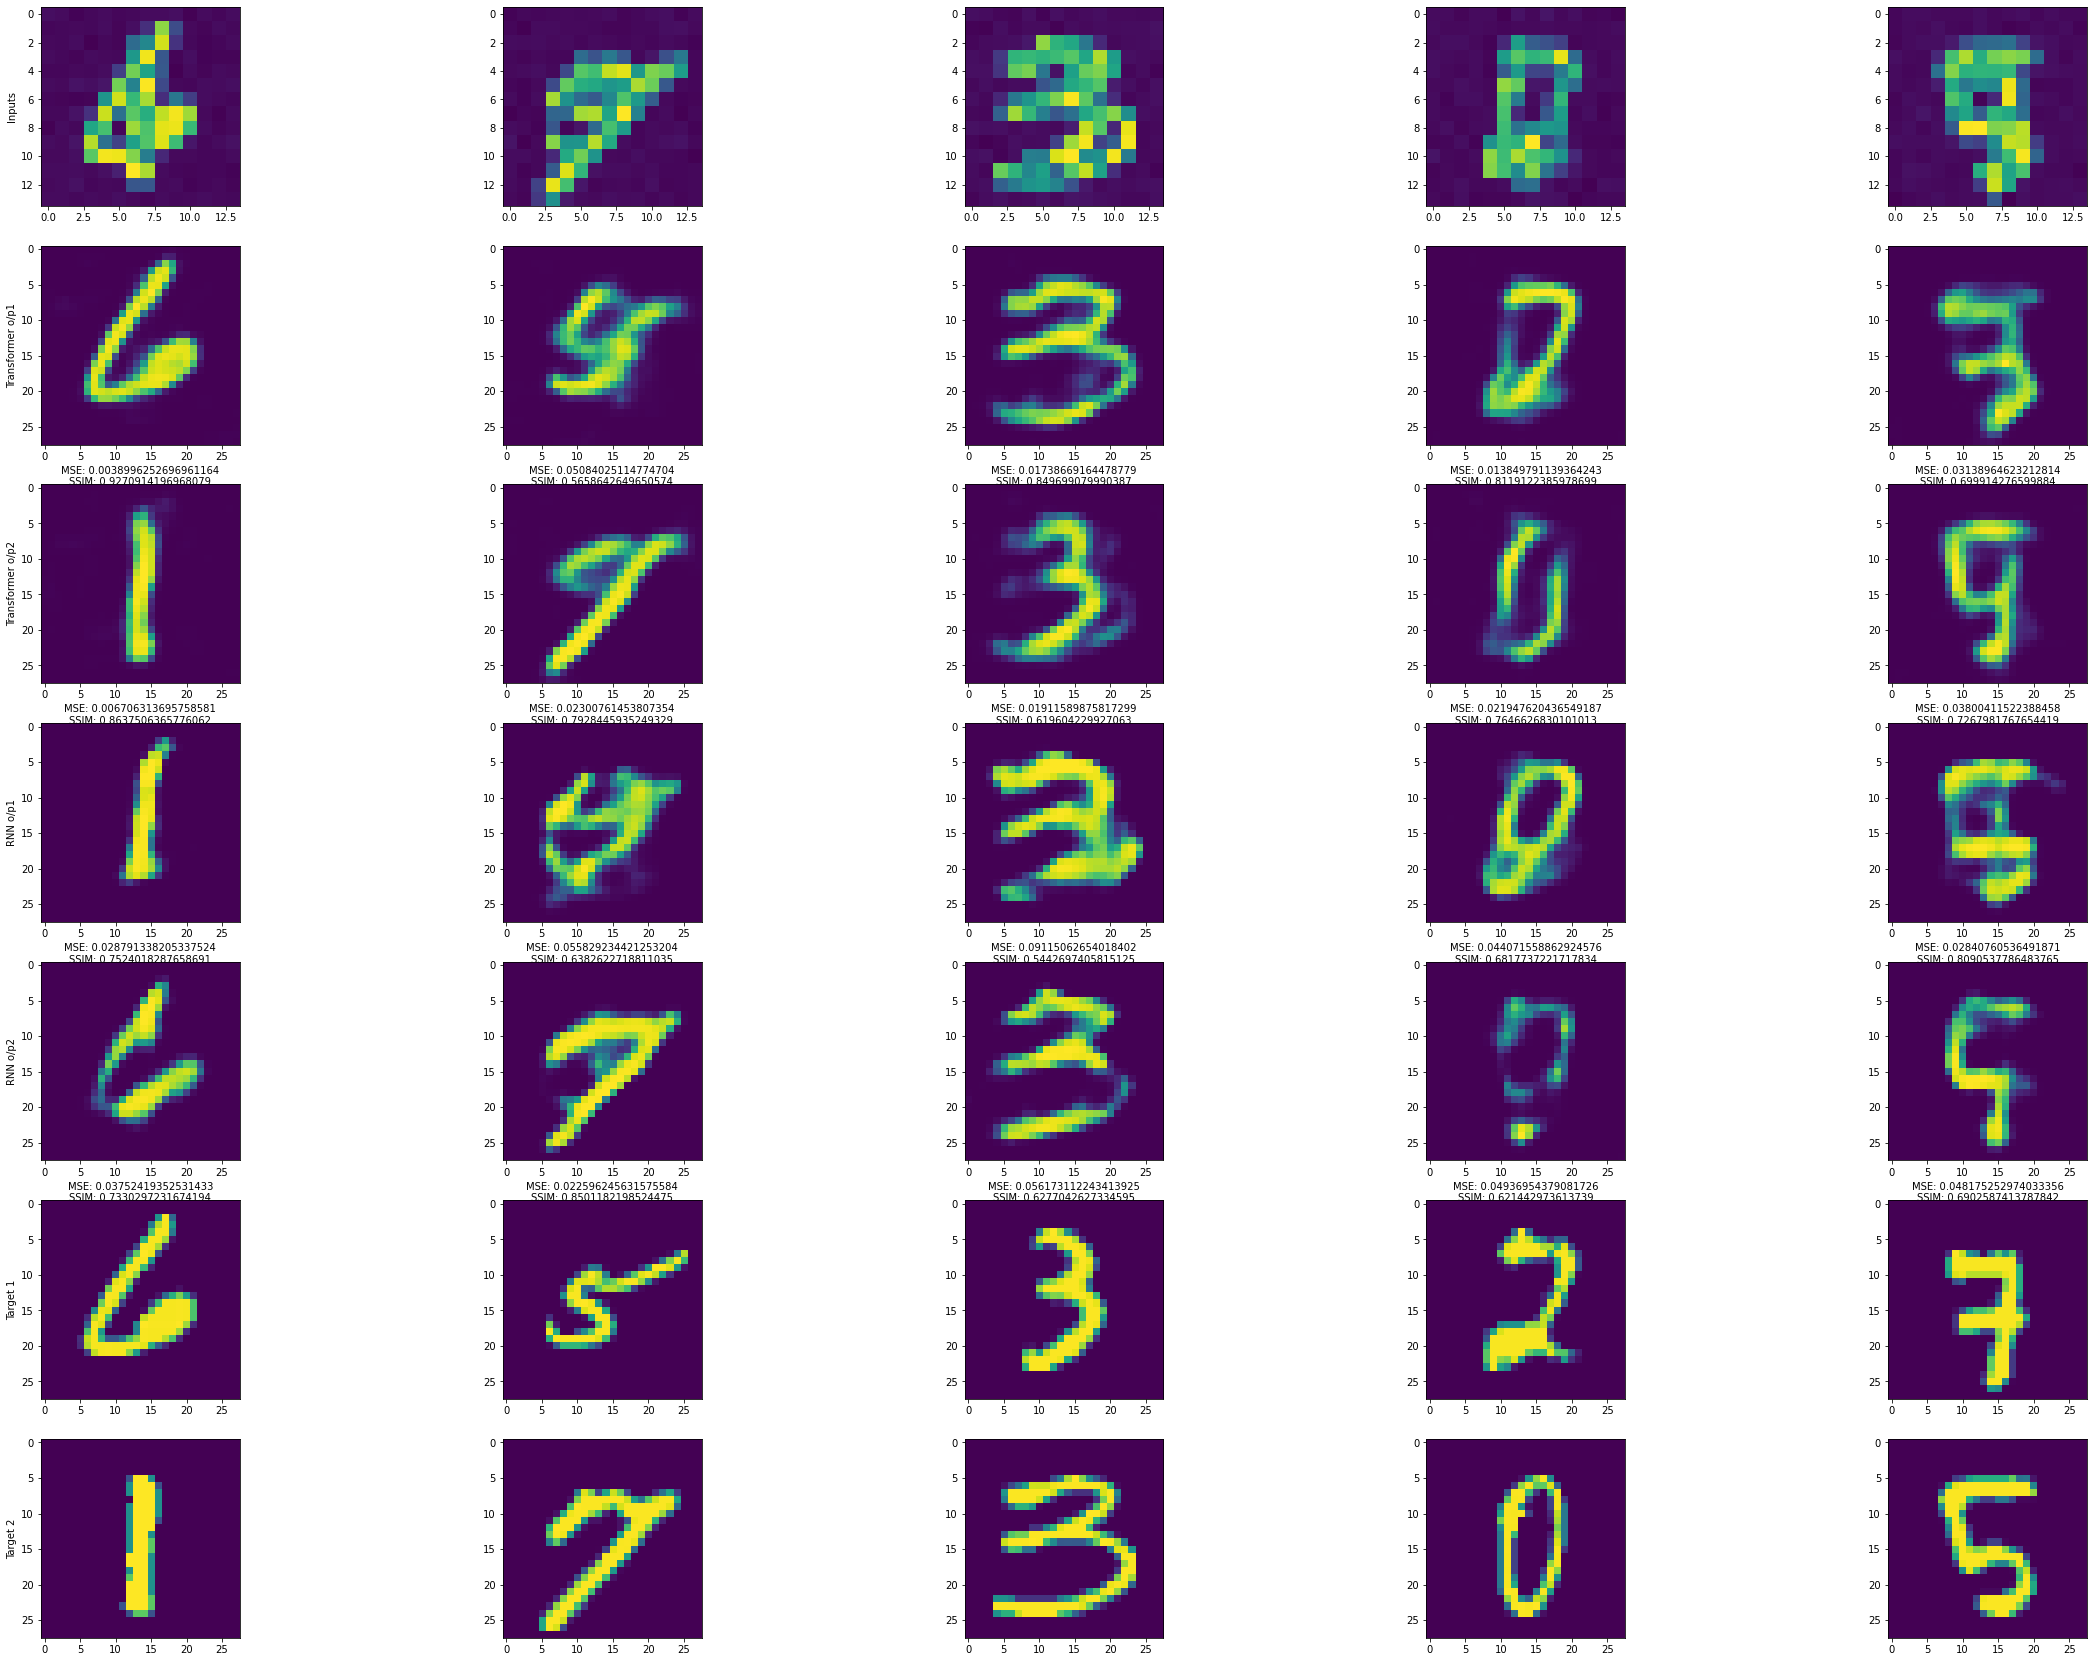

In [5]:
show_outputs_rgb(TransformerOutputs=TransformerOutputs, RNNOutputs= RNNOutputs, targets=targets,inputs= inputs, num_images=5, gray=True)

In [6]:
# Now, let's look at the MSE and SSIM values 
# For now, let's make it sparse
testset = DataLoader(test_supserimposed, batch_size=64, shuffle=False)
T_mse_list, T_ssim_list = fetch_mse_ssim(testset, UpTransformer, transformer = True)
RNN_mse_list, RNN_ssim_list = fetch_mse_ssim(testset, UpRNN, transformer = False)

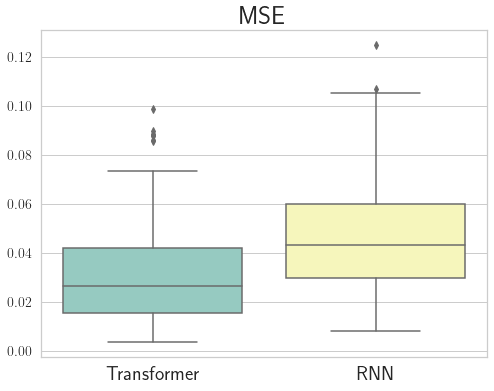

In [8]:
mseDict = {'Transformer':T_mse_list, 'RNN': RNN_mse_list}
ssimDict = {'Transformer': T_ssim_list, 'RNN': RNN_ssim_list}
sns_plotter(mseDict=mseDict, ssimDict=ssimDict, savefig=True)